In [1]:
!pip install gensim
!pip install git+https://github.com/jbesomi/texthero.git
!pip install -q kaggle # to download the dataset
!pip install wordcloud
!pip install -U textblob
!python -m textblob.download_corpora

import pandas as pd
import matplotlib as plt
import seaborn as sns
import texthero as hero
from texthero import stopwords
import os
from wordcloud import WordCloud
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob,Word

import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jbesomi/texthero.git to /tmp/pip-req-build-orkrg0_7
  Running command git clone -q https://github.com/jbesomi/texthero.git /tmp/pip-req-build-orkrg0_7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nlt

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (3.4.1) requires spaCy v3.4 and is incompatible with the current spaCy version (2.3.8). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_excel("dataset_f.xlsx", sheet_name="Sheet1")
df
count = df.groupby(['Tags'])['Projects'].count()
print(count)
count.hist

Tags
Entertainment     193
Finance           202
Game AI           149
Generic ML       1043
Generic Ml          1
Health            380
NLP               428
Robotics          111
Vision            701
entertainment      83
finance            78
game AI            27
generic ML        389
health            146
nlp               268
robotics           40
vision            149
Name: Projects, dtype: int64


<bound method hist_series of Tags
Entertainment     193
Finance           202
Game AI           149
Generic ML       1043
Generic Ml          1
Health            380
NLP               428
Robotics          111
Vision            701
entertainment      83
finance            78
game AI            27
generic ML        389
health            146
nlp               268
robotics           40
vision            149
Name: Projects, dtype: int64>

In [3]:
def clean(txt):
  '''Remove special characters'''
  txt = txt.str.replace("()", "")
  txt = txt.str.replace('(<a).*(>).*()', '')
  txt = txt.str.replace('(&amp)', '')
  txt = txt.str.replace('(&gt)', '')
  txt = txt.str.replace('(&lt)', '')
  txt = txt.str.replace('(\xa0)', ' ')
  return txt
def lemma_per_pos(sent):
  '''function to lemmatize according to part of speech tag'''
  t = TextBlob(sent)
  t_dict = {"J": 'a',"N": 'n',"V": 'v',"R": 'r'}
  w_n_t = [(w, t_dict.get(p[0], 'n')) for w, p in t.tags]
  lemmatized_list = [w.lemmatize(t) for w, t in w_n_t]
  return " ".join(lemmatized_list)

In [6]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

#example text text = 'What can I say about this place. The staff of these restaurants is nice and the eggplant is not bad'

class Splitter(object):
    """
    split the document into sentences and tokenize each sentence
    """
    def __init__(self):
        self.splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.tokenizer = nltk.tokenize.TreebankWordTokenizer()

    def split(self,text):
        """
        out : ['What', 'can', 'I', 'say', 'about', 'this', 'place', '.']
        """
        # split into single sentence
        sentences = self.splitter.tokenize(text)
        # tokenization in each sentences
        tokens = [self.tokenizer.tokenize(sent) for sent in sentences]
        return tokens


class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    def get_wordnet_pos(self,treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

    def pos_tag(self,tokens):
        # find the pos tagginf for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
        pos_tokens = [nltk.pos_tag(token) for token in tokens]

        # lemmatization using pos tagg   
        # convert into feature set of [('What', 'What', ['WP']), ('can', 'can', ['MD']), ... ie [original WORD, Lemmatized word, POS tag]
        pos_tokens = [ [(word, lemmatizer.lemmatize(word,self.get_wordnet_pos(pos_tag)), [pos_tag]) for (word,pos_tag) in pos] for pos in pos_tokens]
        # pos_tokens2 = [ [lemmatizer.lemmatize(word,self.get_wordnet_pos(pos_tag)) for (word,pos_tag) in pos] for pos in pos_tokens]
        return pos_tokens

def lemmatize_sentence(sentence):
  # lemmatizer = WordNetLemmatizer()
  splitter = Splitter()
  lemmatization_using_pos_tagger = LemmatizationWithPOSTagger()

  #step 1 split document into sentence followed by tokenization
  tokens = splitter.split(sentence)

  #step 2 lemmatization using pos tagger 
  lemma_pos_token = lemmatization_using_pos_tagger.pos_tag(tokens)
  lemma_sent = " ".join([x[1] for x in lemma_pos_token[0]])
  return lemma_sent

lemmatize_sentence("side channel cryptanalysis using machine learning and classified into groups")

'side channel cryptanalysis use machine learning and classify into group'

In [7]:
df['Projects'] = df['Projects'].astype(str)
df['Tags'] = df['Tags'].astype(str)

#remove special characters
df['Projects'] = clean(df['Projects'])

#convert to lower case
df['Projects'] = df['Projects'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Tags'] = df['Tags'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove stop words
stop = stopwords.words('english')
df['Projects'] = df['Projects'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

print(df) 

print("lemmatizing")
#lemmatize
# print(df['Projects'][0])
# print("Hello look at this : ", lemmatize_sentence(df['Projects'][0]))
df['Projects'] = df['Projects'].apply(lambda x: lemmatize_sentence(x))
# df['Projects']= [lemmatize_sentence(sent) for sent in df['Projects']]
# # df['Projects'] = df['Projects'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


#remove punctuation
df['Projects'] = df['Projects'].str.replace('[^\w\s]', '')
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: Fu

                                               Projects           Tags  \
0                         predicting freeway congestion         vision   
1     supervised learning query term relevant produc...            nlp   
2                                   robotic arm control       robotics   
3                           network intrusion detection         vision   
4             multi-website name coreference resolution            nlp   
...                                                 ...            ...   
4383  white christmas: remaking augmented reality ce...         vision   
4384                     youtube-8m video understanding         vision   
4385  font-gen: deep models inferring alternate lang...            nlp   
4386  iseebetter: spatio-temporal video super resolu...         vision   
4387                       predicting nba game outcomes  entertainment   

      Unnamed: 2  Unnamed: 3  Unnamed: 4 Unnamed: 5  Unnamed: 6  
0            NaN         NaN         NaN     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future version.


,Projects,Tags,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,predict freeway congestion,vision,NaN,NaN,NaN,NLP,696.0
1,supervise learning query term relevant product...,nlp,NaN,NaN,NaN,Vision,850.0
2,robotic arm control,robotics,NaN,NaN,NaN,Robotics,151.0
3,network intrusion detection,vision,NaN,NaN,NaN,Health,526.0
4,multiwebsite name coreference resolution,nlp,NaN,NaN,NaN,Finance,280.0
...,...,...,...,...,...,...,...
4383,white christmas remaking augment reality cens...,vision,NaN,NaN,NaN,NaN,NaN
4384,youtube8m video understanding,vision,NaN,NaN,NaN,NaN,NaN
4385,fontgen deep model infer alternate language s...,nlp,NaN,NaN,NaN,NaN,NaN
4386,iseebetter spatiotemporal video super resolut...,vision,NaN,NaN,NaN,NaN,NaN


In [9]:
count = df.groupby(['Tags'])['Projects'].count()
print(count)
count.hist

Tags
entertainment     276
finance           280
game ai           176
generic ml       1433
health            526
nlp               696
robotics          151
vision            850
Name: Projects, dtype: int64


<bound method hist_series of Tags
entertainment     276
finance           280
game ai           176
generic ml       1433
health            526
nlp               696
robotics          151
vision            850
Name: Projects, dtype: int64>

                                               Projects           Tags  \
0                            predict freeway congestion         vision   
1     supervise learning query term relevant product...            nlp   
2                                   robotic arm control       robotics   
3                           network intrusion detection         vision   
4              multiwebsite name coreference resolution            nlp   
...                                                 ...            ...   
4383  white christmas  remaking augment reality cens...         vision   
4384                      youtube8m video understanding         vision   
4385  fontgen  deep model infer alternate language s...            nlp   
4386  iseebetter  spatiotemporal video super resolut...         vision   
4387                           predict nba game outcome  entertainment   

      Unnamed: 2  Unnamed: 3  Unnamed: 4 Unnamed: 5  Unnamed: 6  len  
0            NaN         NaN         NaN

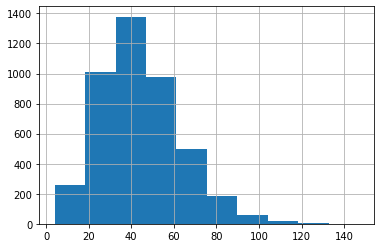

In [10]:
#sentence length analysis
df['len']= df['Projects'].str.len()
print(df)
print('Max length: {}, Min length: {}, Average Length :  {}'.format(max(df['len']),min(df['len']),df['len'].mean()))
df['len'].hist()

In [11]:
#BOW
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
# def bag_of_words():
  # Create the bag of words feature matrix
count = CountVectorizer()
bag_of_words = count.fit_transform(df["Projects"])

# Show feature matrix
bag_of_words.toarray()
# Get feature names
feature_names = count.get_feature_names()

# View feature names
feature_names
  # Create data frame
bow = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
bow
# bag_of_words()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,10,100,1000,10k,13k,182,1s1r,20,200,2002,...,youtube,youtube8m,yupôøωik,zero,zombie,zone,zoo,zoom,zsy,ââœi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4384,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def word_level_analysis(df_group, group_name):
#word level analysis
  print("For group : ", group_name)
  text= ' '.join(t for t in df_group['Projects'])
  words_list= text.split()

  word_freq= {}
  for word in set(words_list):
      word_freq[word]= words_list.count(word)
  #Creating dataframe of words
  df_word= pd.DataFrame(word_freq.items(),columns=['word','count'])

  df_word['word_len']= df_word['word'].map(lambda x: len(x))
  # sorting values 
  df_word=df_word.sort_values('count',ascending=False).reset_index(drop=True)
  df_word

  #get first 50
  df_word.head(50)

  #most common 50 words
  df_top= df_word.head(30)
  import matplotlib.pyplot as plt
  plt.figure(figsize=(10,10))
  sns.barplot(df_top['count'],df_top['word'])


In [15]:
#most common 50 words
df_top= df.head(10)
sns.barplot(df_top['count'],df_top['word'])


KeyError: ignored

In [14]:
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color='white',max_words=100,
                      max_font_size=60,
                      scale=20,
                      random_state=1).generate(text)
plt.axis("off")
plt.imshow(wordcloud)

NameError: ignored

               Projects
Tags                   
entertainment       276
finance             280
game ai             176
generic ml         1433
health              526
nlp                 696
robotics            151
vision              850


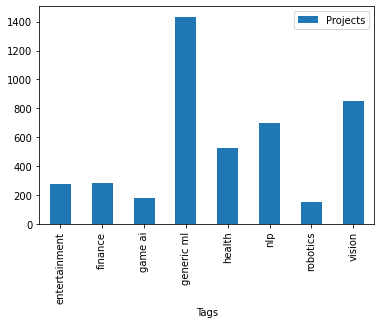

In [16]:
df_count=df[['Projects', 'Tags']].groupby(['Tags']).count()
print(df_count)
df_count.plot.bar()

In [20]:
df2 = df.groupby(['Tags'])

For group :  entertainment


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


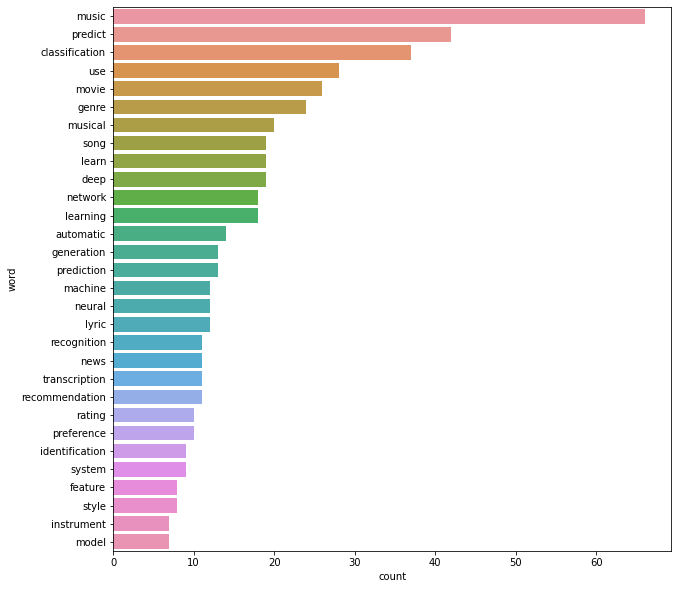

In [21]:
tags_tuple = ["entertainment", "finance"]#, "game ai", "generic ml", "health", "nlp", "robotics", "vision"]
word_level_analysis(df2.get_group("entertainment"), "entertainment")



For group :  vision


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


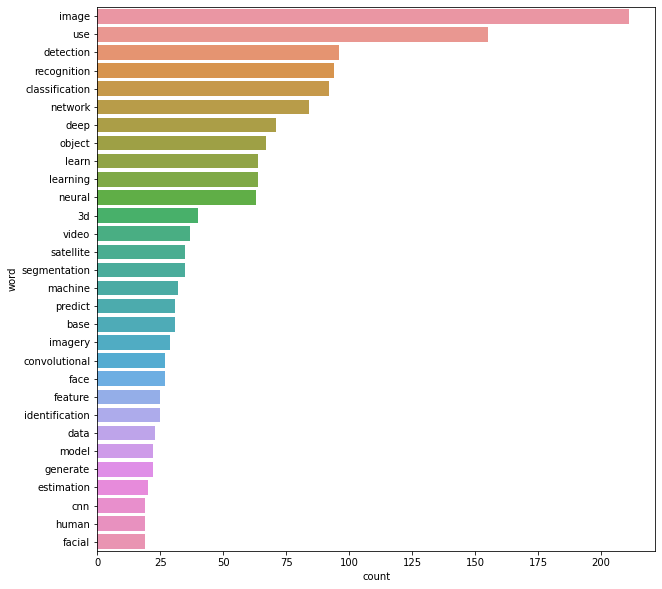

In [22]:

word_level_analysis(df2.get_group("vision"), "vision")

For group :  robotics


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


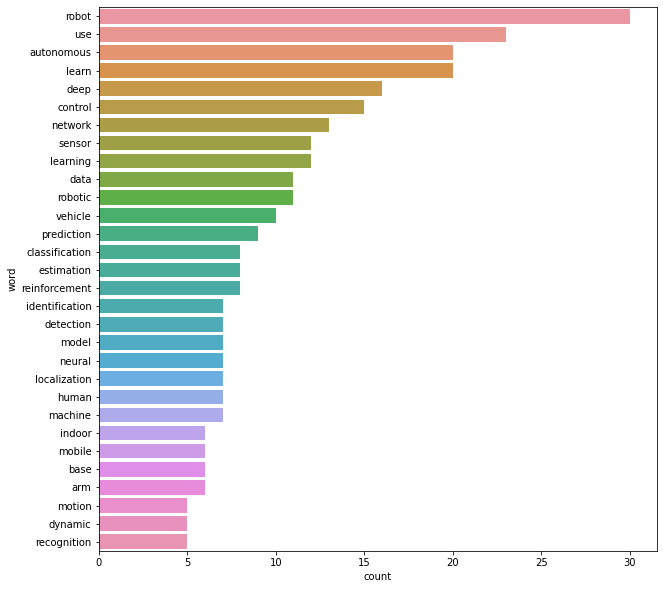

In [23]:

word_level_analysis(df2.get_group("robotics"), "robotics")

For group :  health


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


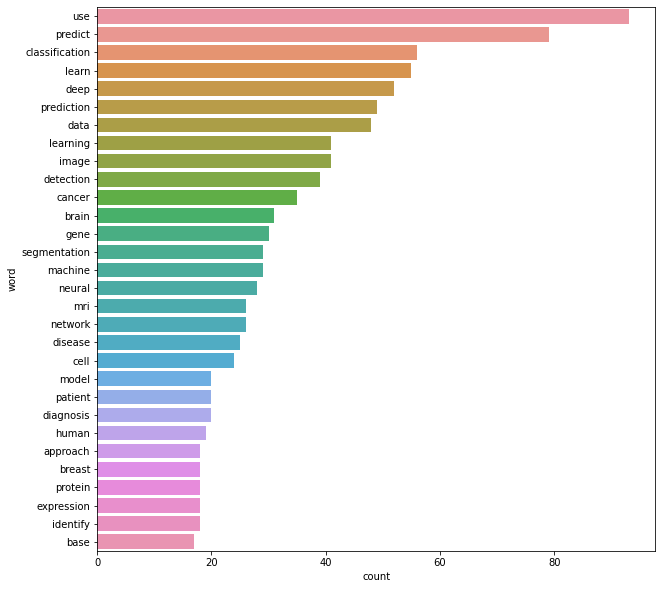

In [24]:

word_level_analysis(df2.get_group("health"), "health")

For group :  nlp


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


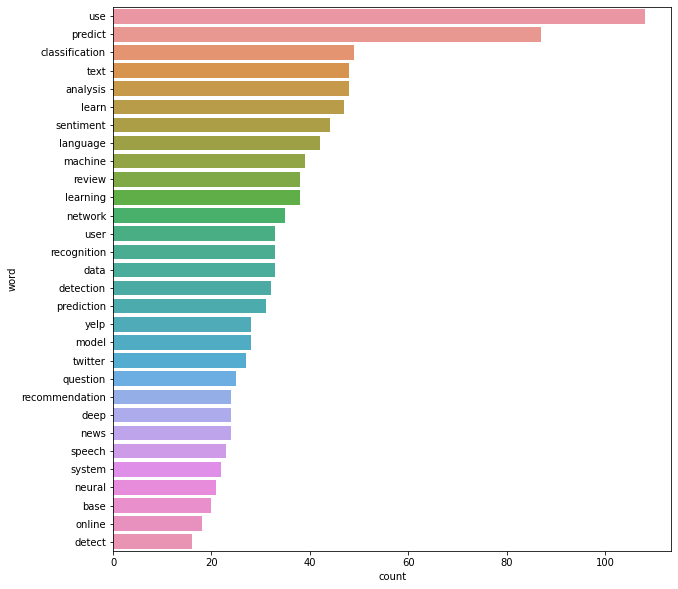

In [25]:

word_level_analysis(df2.get_group("nlp"), "nlp")

For group :  game ai


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


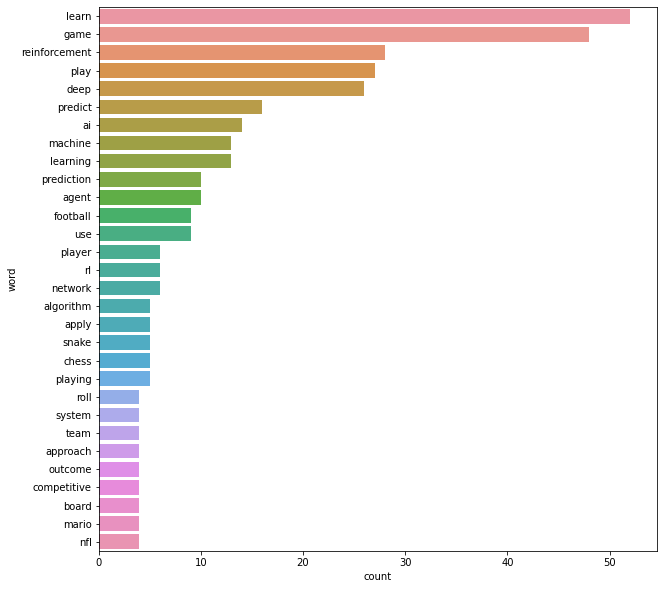

In [26]:
word_level_analysis(df2.get_group("game ai"), "game ai")

For group :  generic ml


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


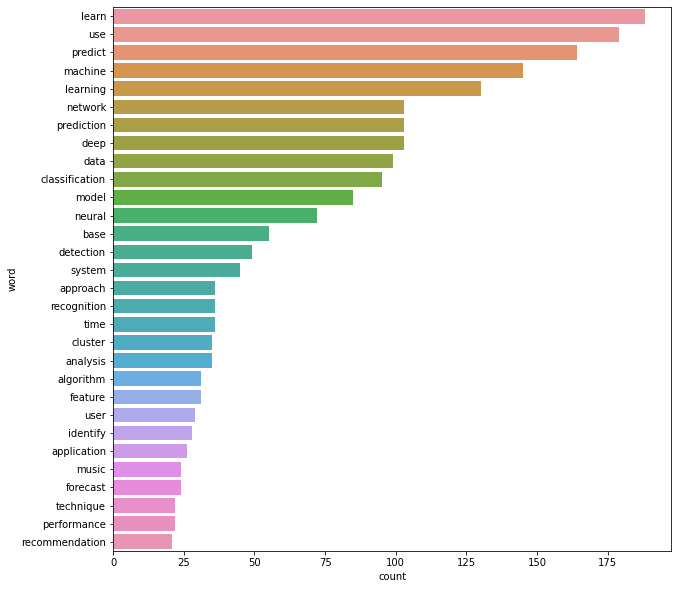

In [27]:
word_level_analysis(df2.get_group("generic ml"), "generic ml")

For group :  finance


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


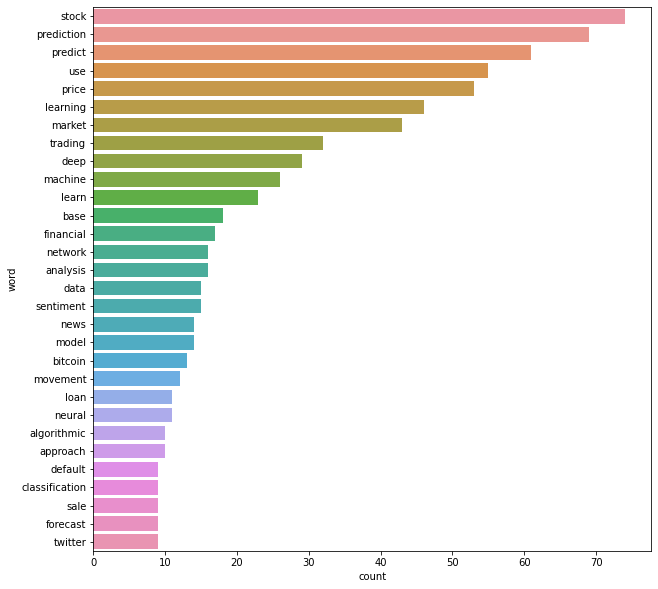

In [28]:
word_level_analysis(df2.get_group("finance"), "finance")

In [30]:
#tf idf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cvec = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,1))
cvec
df_clean = df[['Projects', 'Tags']].groupby(['Tags']).agg({'Projects' : ' '.join})
print(df_clean.shape)
df_clean.head(50)




(8, 1)


,Projects
Tags,
entertainment,machine learn algorithms musical instrument re...
finance,neural network approach option pricing stock t...
game ai,snake robot motion plan climb obstacle beat ca...
generic ml,classification network flow eigenface base app...
health,probabilistic independent component analysis f...
nlp,supervise learning query term relevant product...
robotics,robotic arm control control parameter optimiza...
vision,predict freeway congestion network intrusion d...


In [32]:
from itertools import islice
print(df_clean.shape)

cvec.fit(df_clean.Projects)
print(list(islice(cvec.vocabulary_.items(), 40)))
print(len(cvec.vocabulary_))

(8, 1)
[('instrument', 2009), ('reinforce', 3266), ('genre', 1643), ('vocal', 4198), ('popular', 2976), ('dance', 942), ('sheet', 3550), ('alignment', 148), ('note', 2683), ('mixture', 2467), ('gaussians', 1621), ('tempo', 3895), ('user', 4120), ('keyboard', 2123), ('acoustic', 68), ('emanation', 1289), ('netflix', 2620), ('prize', 3059), ('logistic', 2264), ('modelling', 2481), ('waveformbased', 4234), ('connection', 785), ('peertopeer', 2856), ('stream', 3757), ('rotten', 3395), ('tomato', 3960), ('hmm', 1837), ('drum', 1208), ('travel', 4019), ('query', 3150), ('gesture', 1656), ('composer', 744), ('restore', 3330), ('focus', 1534), ('photograph', 2900), ('engine', 1328), ('rating', 3185), ('enriched', 1335), ('metadata', 2409), ('recover', 3227)]
4325


In [33]:
cvec_counts = cvec.transform(df_clean.Projects)
print('sparse matrix shape:', cvec_counts.shape)
# print(cvec_counts[0,:])
print('nonzero count:', cvec_counts.nnz)
print( 'sparsity: ', (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (8, 4325)
nonzero count: 6762
sparsity:  19.54335260115607


In [34]:

occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
# occ = np.asarray(cvec_counts).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)
# print(counts_df.shape)
# print(counts_df.head(20))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,term,occurrences
2707,object,78
4120,user,70
1643,genre,40
4058,twitter,40
521,cancer,40
466,brain,37
3185,rating,36
1418,expression,36
1917,imagery,31
1434,face,30


In [35]:
cvec.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10',
 '100',
 '1000',
 '10k',
 '13k',
 '182',
 '1s1r',
 '20',
 '200',
 '2002',
 '2006',
 '2016',
 '2018',
 '2019',
 '2048',
 '229',
 '25',
 '27',
 '2d',
 '2k19',
 '2stage',
 '3dcnn',
 '3nt',
 '3point',
 '4d',
 '4waystop',
 '500',
 '532',
 '64bit',
 '6dof',
 '72',
 '7minute',
 '85th',
 '8k',
 'abdominal',
 'ability',
 'abnormal',
 'abnormality',
 'abovethefold',
 'abraham',
 'absolute',
 'absoption',
 'absorption',
 'abstention',
 'abstract',
 'abstractdcgan',
 'abstraction',
 'abstractive',
 'abuse',
 'abusive',
 'academia',
 'academic',
 'academy',
 'accelerate',
 'accelerated',
 'acceleration',
 'accelerometer',
 'accent',
 'acceptance',
 'access',
 'accessibility',
 'accident',
 'accomplish',
 'accord',
 'account',
 'accuracy',
 'accurate',
 'achieve',
 'acoustic',
 'acousticphonetic',
 'acquisition',
 'acrosssubject',
 'activation',
 'active',
 'activitytransitionrecognition',
 'actor',
 'actuator',
 'acute',
 'ad',
 'adaboost',
 'adam',
 'adapatation',
 'adaptation',
 'add',
 'a

In [36]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<8x4325 sparse matrix of type '<class 'numpy.float64'>'
	with 6762 stored elements in Compressed Sparse Row format>

In [55]:
weights_mean = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_max_class = np.asarray(transformed_weights.argmax(axis=0)).ravel().tolist()
print(len(weights_mean))
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'avg_weight': weights_mean, 'max_TF-IDF_class': weights_max_class})
# weights_df.head(20)
weights_df.sort_values(by='avg_weight', ascending=False).head(20)

4325


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,term,avg_weight,max_TF-IDF_class
4120,user,0.086220,5
2707,object,0.081403,7
1643,genre,0.073738,0
4058,twitter,0.063567,5
3376,robotic,0.059747,6
1542,football,0.055448,2
3645,song,0.055410,0
3185,rating,0.052816,0
1493,financial,0.045244,1
2298,lyric,0.041165,0


In [38]:
tf_idf_vision = weights_df.groupby(['max_TF-IDF_class']).get_group(7).sort_values(by = 'avg_weight', ascending=False)

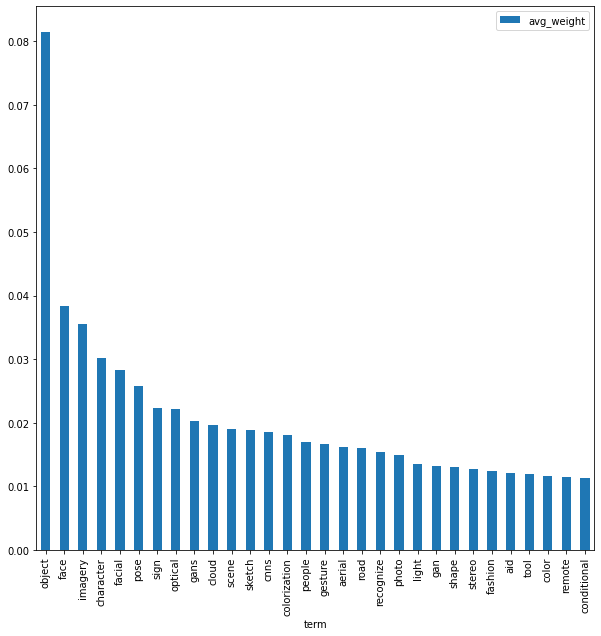

In [39]:
tf_idf_vision.head(30).plot.bar(x='term', y='avg_weight', figsize=(10,10))

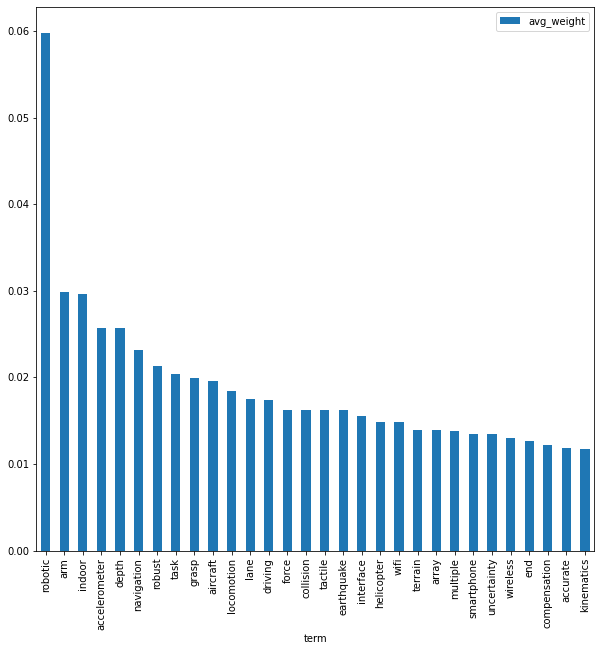

In [40]:
tf_idf_robotics = weights_df.groupby(['max_TF-IDF_class']).get_group(6).sort_values(by = 'avg_weight', ascending=False)
tf_idf_robotics.head(30).plot.bar(x='term', y='avg_weight', figsize=(10,10))

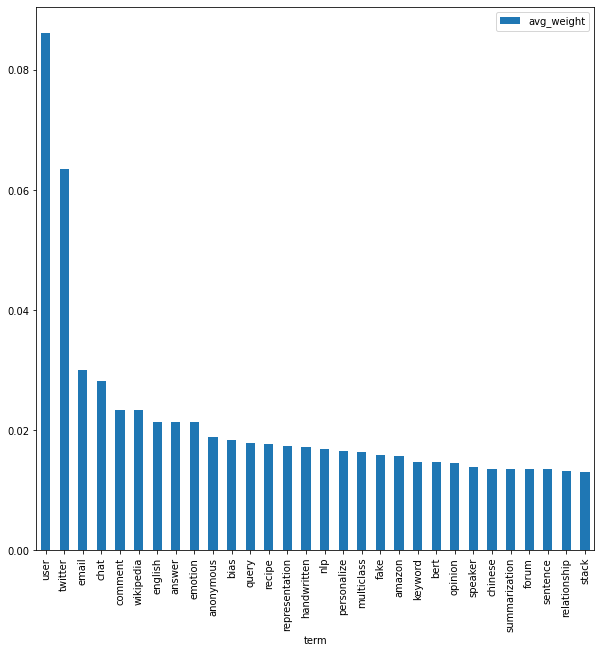

In [41]:
tf_idf_nlp = weights_df.groupby(['max_TF-IDF_class']).get_group(5).sort_values(by = 'avg_weight', ascending=False)
tf_idf_nlp.head(30).plot.bar(x='term', y='avg_weight', figsize=(10,10))

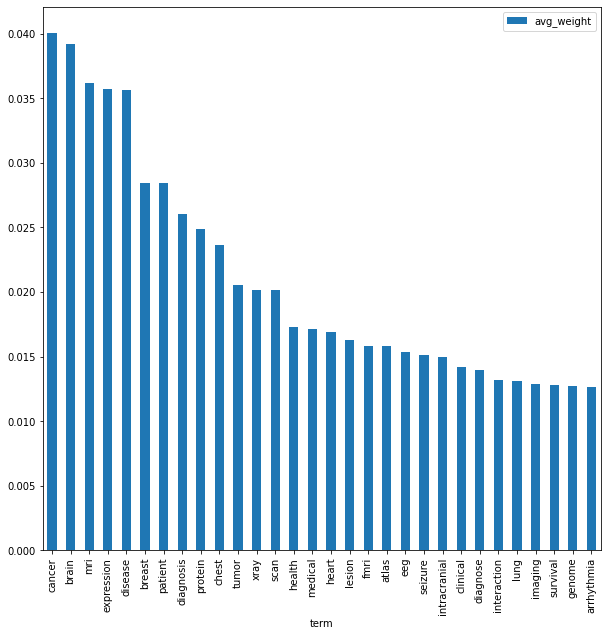

In [42]:
tf_idf_health = weights_df.groupby(['max_TF-IDF_class']).get_group(4).sort_values(by = 'avg_weight', ascending=False)
tf_idf_health.head(30).plot.bar(x='term', y='avg_weight', figsize=(10,10))

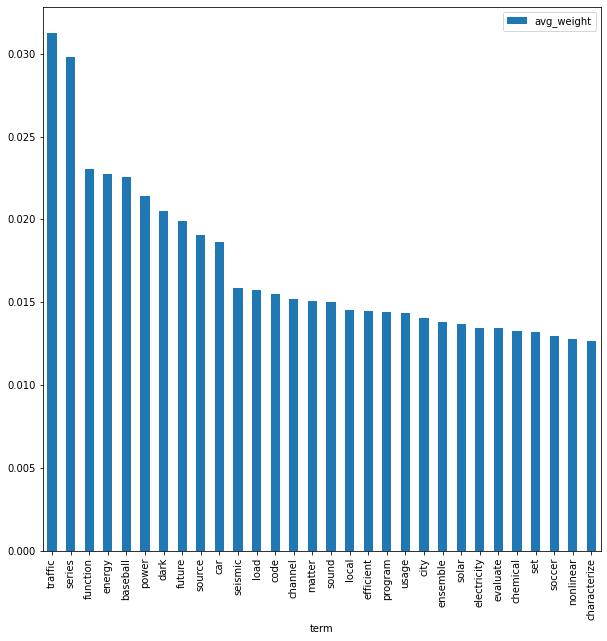

In [43]:
tf_idf_generic_ML = weights_df.groupby(['max_TF-IDF_class']).get_group(3).sort_values(by = 'avg_weight', ascending=False)
tf_idf_generic_ML.head(30).plot.bar(x='term', y='avg_weight', figsize=(10,10))

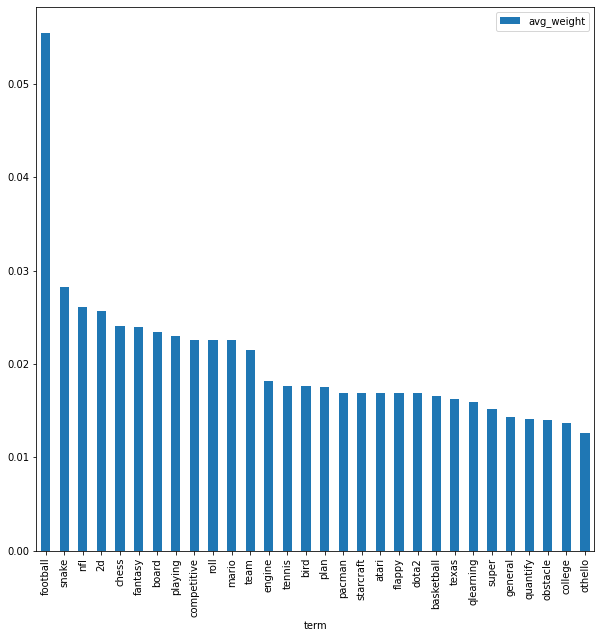

In [44]:
tf_idf_game_AI = weights_df.groupby(['max_TF-IDF_class']).get_group(2).sort_values(by = 'avg_weight', ascending=False)
tf_idf_game_AI.head(30).plot.bar(x='term', y='avg_weight', figsize=(10,10))

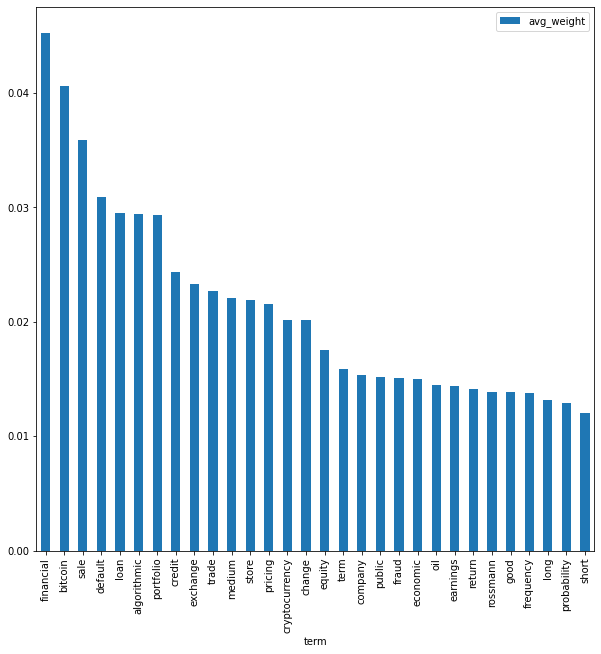

In [45]:
tf_idf_finance = weights_df.groupby(['max_TF-IDF_class']).get_group(1).sort_values(by = 'avg_weight', ascending=False)
tf_idf_finance.head(30).plot.bar(x='term', y='avg_weight', figsize=(10,10))

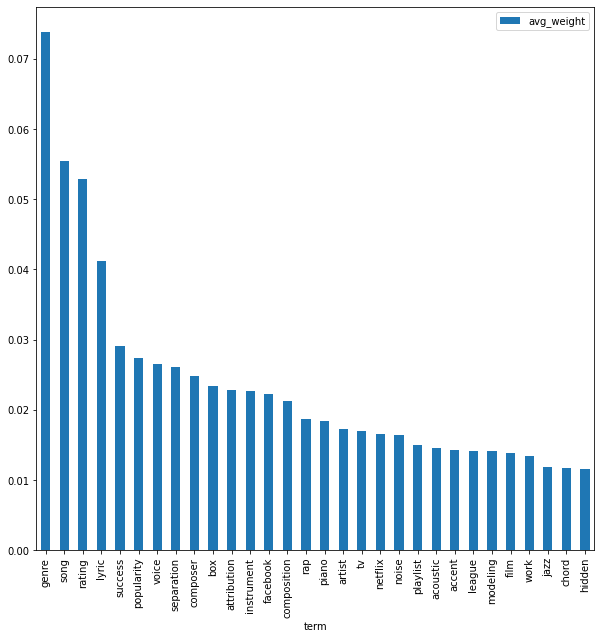

In [46]:
tf_idf_entertainment = weights_df.groupby(['max_TF-IDF_class']).get_group(0).sort_values(by = 'avg_weight', ascending=False)
tf_idf_entertainment.head(30).plot.bar(x='term', y='avg_weight', figsize=(10,10))